In [110]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from copy import deepcopy
import galsim
from scipy.stats import chi2

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats, regions
from mejiro.utils import util
from mejiro.lenses import lens_util
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure

In [111]:
print(f'Collecting lenses...')
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir
lens_list = lens_util.get_detectable_lenses(pipeline_dir, suppress_output=False)
lens_list = [lens for lens in lens_list if lens.snr > 50 and lens.get_einstein_radius() > 0.5]
print(f'Collected {len(lens_list)} lenses.')

100%|██████████| 18/18 [00:00<00:00, 44.89it/s]

Collected 30 lenses.


In [112]:
lens = np.random.choice(lens_list)
print(lens.snr)

111.4888092034621


In [113]:
# lens = SampleStrongLens()
roman = Roman()

band = 'F087'
scene_size = 5  # arcsec
oversample = 5
config = {'sca': 1,
          'sca_position': (2048, 2048)}
exposure_time = 146000

rng = galsim.UniformDeviate(42)

# solve for image positions
image_x, image_y = lens.get_image_positions(pixel_coordinates=False)
print(f'Image positions: {image_x}, {image_y}')
# image_x_pixel, image_y_pixel = lens.get_image_positions(pixel_coordinates=True)
# print(f'Image positions (pixel): {image_x_pixel}, {image_y_pixel}')
num_images = len(image_x)

Image positions: [-0.38388349 -0.01907039], [ 0.94889744 -0.1695207 ]


In [114]:
m200 = 1e11
concentration = 6

Rs_angle, alpha_Rs = lens.lens_cosmo.nfw_physical2angle(M=m200, c=concentration)
print(f'{Rs_angle=}, {alpha_Rs=}')

rand_idx = np.random.randint(0, num_images)
halo_x, halo_y = image_x[rand_idx], image_y[rand_idx]
print(f'{halo_x=}, {halo_y=}')

subhalo_type = 'TNFW'
kwargs_subhalo = {'alpha_Rs': alpha_Rs, 'Rs': Rs_angle, 'center_x': halo_x, 'center_y': halo_y, 'r_trunc': 5 * Rs_angle}

Rs_angle=3.17874549508472, alpha_Rs=0.03293396528118334
halo_x=-0.019070391424485786, halo_y=-0.16952070415028272


Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00000300 by Roman in F087 band


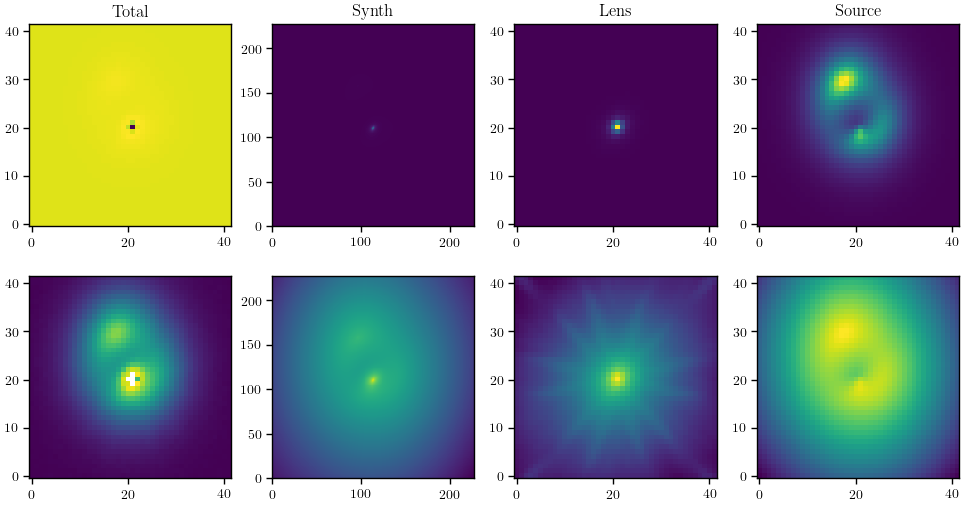

In [115]:
lens_no_subhalo = deepcopy(lens)
synth_no_subhalo = SyntheticImage(lens_no_subhalo, roman, band=band, arcsec=scene_size, oversample=oversample, pieces=True, **config)
exposure_no_subhalo = Exposure(synth_no_subhalo, exposure_time=exposure_time, rng=rng, **config, return_noise=True)

# get pieces
lens_exposure = exposure_no_subhalo.lens_exposure
source_exposure = exposure_no_subhalo.source_exposure

# get noise
poisson_noise = exposure_no_subhalo.poisson_noise
dark_noise = exposure_no_subhalo.dark_noise
read_noise = exposure_no_subhalo.read_noise

_, ax = plt.subplots(2, 4, figsize=(12, 6))
ax[0, 0].imshow(exposure_no_subhalo.exposure)
ax[1, 0].imshow(np.log10(exposure_no_subhalo.exposure))
ax[0, 1].imshow(synth_no_subhalo.image)
ax[1, 1].imshow(np.log10(synth_no_subhalo.image))
ax[0, 2].imshow(lens_exposure)
ax[1, 2].imshow(np.log10(lens_exposure))
ax[0, 3].imshow(source_exposure)
ax[1, 3].imshow(np.log10(source_exposure))
ax[0, 0].set_title('Total')
ax[0, 1].set_title('Synth')
ax[0, 2].set_title('Lens')
ax[0, 3].set_title('Source')
plt.show()

calculate SNR mask

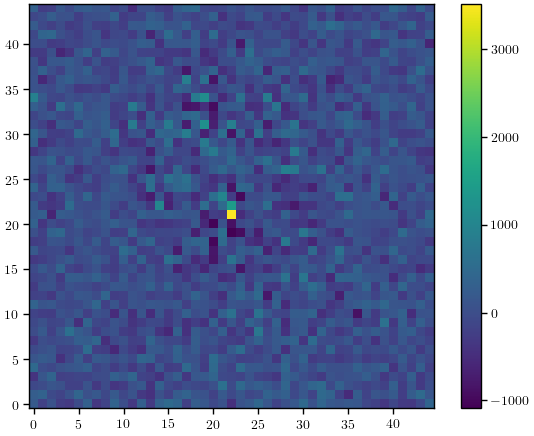

In [116]:
noise = poisson_noise.array + dark_noise.array + read_noise.array

plt.imshow(noise)
plt.colorbar()
plt.show()

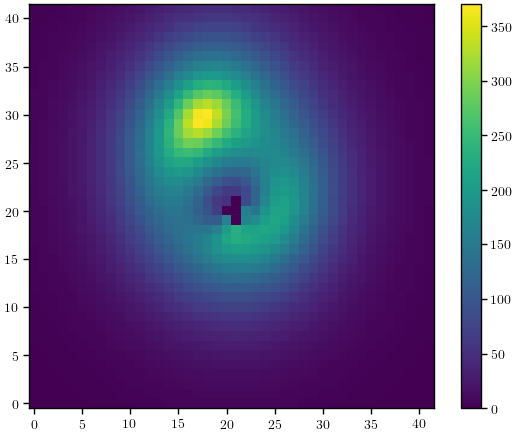

In [117]:
# calculate SNR in each pixel
snr_array = np.nan_to_num(source_exposure / np.sqrt(exposure_no_subhalo.exposure))

plt.imshow(snr_array)
plt.colorbar()
plt.show()

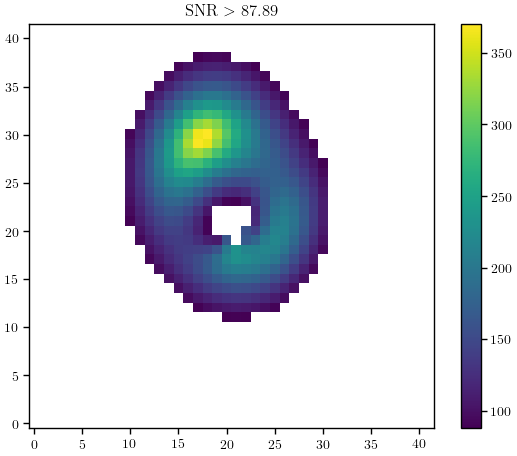

In [118]:
snr_threshold = np.quantile(snr_array, 0.75)
masked_snr_array = np.ma.masked_where(snr_array <= snr_threshold, snr_array)

plt.imshow(masked_snr_array)
plt.colorbar()
plt.title(f'SNR $>$ {snr_threshold:.2f}')
plt.show()

In [119]:
# calculate regions of connected pixels given the snr mask
indices_list = regions.get_regions(masked_snr_array)

snr_list = []
for region in indices_list:
    numerator, denominator = 0, 0
    for i, j in region:
        numerator += source_exposure[i, j]
        denominator += source_exposure[i, j] + lens_exposure[i, j] + noise[i, j]
    if denominator <= 0.:
        continue
    snr = numerator / np.sqrt(denominator)
    assert not np.isnan(snr), 'NaN in SNR list'
    assert not np.isinf(snr), 'Inf in SNR list'
    snr_list.append(snr)

print(f'Calculated SNRs: {snr_list}')

Calculated SNRs: [3477.335988000792]


# TODO assert image position is unmasked

In [121]:
# images_unmasked = False

# while not images_unmasked:
#     if 

get exposure with subhalo

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00000300 by Roman in F087 band


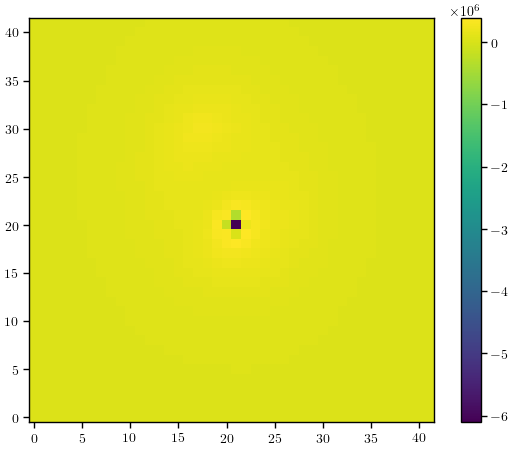

In [122]:
lens_with_subhalo = deepcopy(lens)
lens_with_subhalo.add_subhalo(subhalo_type, kwargs_subhalo)
synth = SyntheticImage(lens_with_subhalo, roman, band=band, arcsec=scene_size, oversample=oversample, **config)
exposure = Exposure(synth, exposure_time=exposure_time, rng=rng, **config, poisson_noise=poisson_noise, dark_noise=dark_noise, read_noise=read_noise)

plt.imshow(exposure.exposure)
plt.colorbar()
plt.show()

mask both

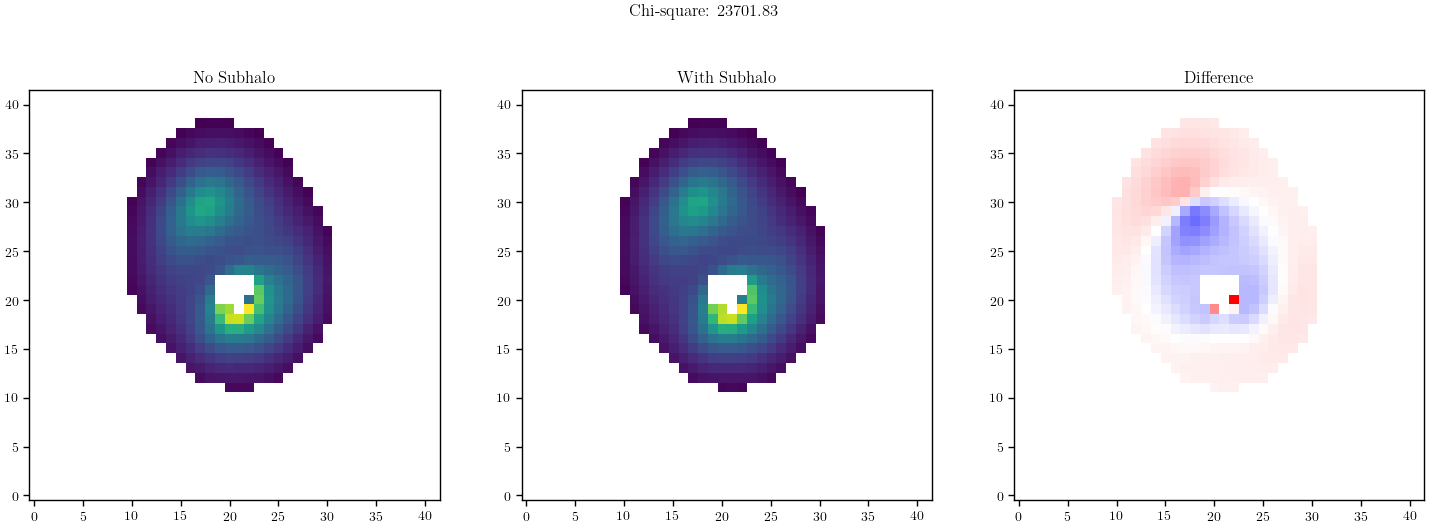

In [123]:
mask = np.ma.getmask(masked_snr_array)
masked_exposure_with_subhalo = np.ma.masked_array(exposure.exposure, mask=mask)
masked_exposure_no_subhalo = np.ma.masked_array(exposure_no_subhalo.exposure, mask=mask)

residual = masked_exposure_with_subhalo - masked_exposure_no_subhalo
vmax = np.max(np.abs(residual))

chi_square = stats.chi_square(np.ma.compressed(masked_exposure_with_subhalo), np.ma.compressed(masked_exposure_no_subhalo))

_, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(masked_exposure_no_subhalo)
ax[0].set_title('No Subhalo')
ax[1].imshow(masked_exposure_with_subhalo)
ax[1].set_title('With Subhalo')
ax[2].imshow(residual, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[2].set_title('Difference')
plt.suptitle(f'Chi-square: {chi_square:.2f}')
plt.show()

compare chi2 of masked and unmasked

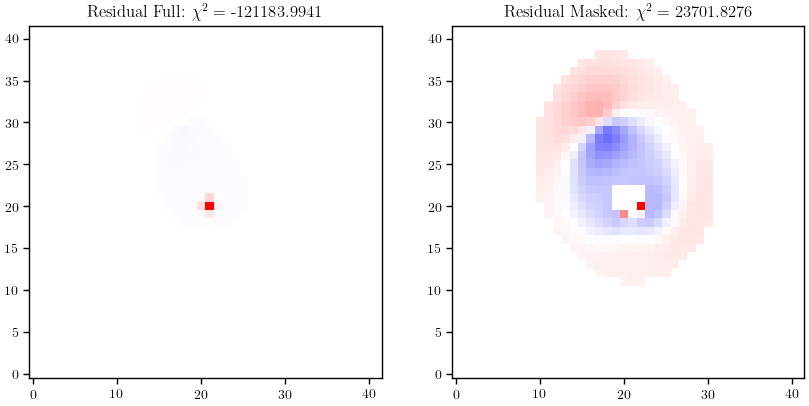

In [124]:
residual_full = exposure.exposure - exposure_no_subhalo.exposure
chi_square_full = stats.chi_square(exposure.exposure, exposure_no_subhalo.exposure)
vmax_full = np.max(np.abs(residual_full))

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(residual_full, cmap='bwr', vmin=-vmax_full, vmax=vmax_full)
ax[0].set_title('Residual Full: ' + r'$\chi^2=$ ' + f'{chi_square_full:.4f}')
ax[1].imshow(residual, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[1].set_title('Residual Masked: ' + r'$\chi^2=$ ' + f'{chi_square:.4f}')
plt.show()

calculate sigmas of masked and unmasked

In [125]:
pixels_full = exposure.exposure.shape[0] * exposure.exposure.shape[1]
dof_full = pixels_full - 3
p_value_full = chi2.sf(chi_square_full, dof_full)
print(f'Full p-value: {p_value_full:.4f}')

pixels_unmasked = np.ma.count(masked_snr_array)
dof_masked = pixels_unmasked - 3
p_value_masked = chi2.sf(chi_square, dof_masked)
print(f'Masked p-value: {p_value_masked:.4f}')

Full p-value: 1.0000
Masked p-value: 0.0000


In [126]:
pval_threshold = 0.001  # three sigma

threshold_full = chi2.isf(pval_threshold, dof_full)
threshold_masked = chi2.isf(pval_threshold, dof_masked)

print(f'Full threshold: {threshold_full:.2f}')
print(f'Masked threshold: {threshold_masked:.2f}')

Full threshold: 1950.11
Masked threshold: 535.19
